In [1]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib

In [2]:

#   --------------------------- parameters and data --------------
PATH = '../resources/inventory/'
supplier_list = [200051]  #200067 -julia, 200051 - donson
# Needs to open files and save them again as xlsx inside the excel

# important needs to delete first column of date which is empty
df = pd.read_excel(PATH + 'customer_transactions.xlsx', parse_dates=['Date'])  # inventory/transactions/reports/detailed/customer shipments
df.columns.values[0] = 'empty'
df.columns.values[3] = 'Date'

purchase_data_df = pd.read_excel(PATH + 'purchase_parameters.xlsx')#  invetory/part catalog/part parameter/purchae MRP parameters for parts
purchase_data_df = purchase_data_df[purchase_data_df['Preferred Vendor'].isin(supplier_list)]
availability_df = pd.read_excel(PATH + 'availability.xlsx')  # inventory/part catalog/parts report/ parts availability detailed
#start_date = '07/12/21'  # all information retrieved from the ERP# software will be discarded. format 'dd\mm\yy'
#start_date = start_date.split('/')[0] + '/' + start_date.split('/')[1] + '/' + start_date.split('/')[2]  # changing order


FileNotFoundError: [Errno 2] No such file or directory: '../resources/inventory/customer_transactions.xlsx'

Mouse wheel scrolled down
Mouse wheel scrolled down
error with   part:  UW-M12
index 1 is out of bounds for axis 0 with size 1
Mouse wheel scrolled down
Mouse wheel scrolled down
error with   part:  UFP00157
index 0 is out of bounds for axis 0 with size 0
Mouse wheel scrolled up
Mouse wheel scrolled down
error with   part:  UFP00157
index 0 is out of bounds for axis 0 with size 0
Mouse wheel scrolled down
error with   part:  STP-0131-2000H
index 0 is out of bounds for axis 0 with size 0
Mouse wheel scrolled down
Mouse wheel scrolled down
error with   part:  STP-0129-1535H
index 1 is out of bounds for axis 0 with size 1
Mouse wheel scrolled down
error with   part:  STP-0129-1378H
index 0 is out of bounds for axis 0 with size 0
Mouse wheel scrolled down
Mouse wheel scrolled down
Mouse wheel scrolled down
Mouse wheel scrolled down
error with   part:  STP-0124-1575A
index 1 is out of bounds for axis 0 with size 1
Mouse wheel scrolled down
Mouse wheel scrolled down
error with   part:  STP-0

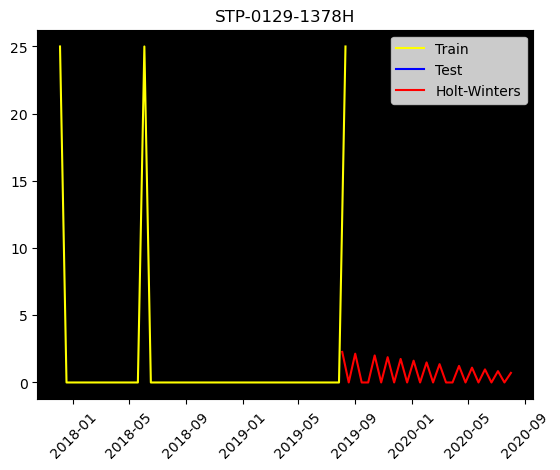

In [39]:
pn_list = list(purchase_data_df['Part Number'].unique())
my_order = np.zeros(len(pn_list))
order_part_list =np.zeros(len(pn_list), dtype=object)
forcast_steps = 12
avail_list = np.zeros(len(pn_list))
security_stock_list = np.zeros(len(pn_list))
recommended_order_list = np.zeros(len(pn_list))
sampling_period = 'M'
how_many_weeks = 4
start_date = '2016-07-01'
forecast_list = np.zeros(len(pn_list))
train_test_ratio = 1
#pn_list = ['A12-1016', 'A12-1270']
part_index = 0
fig, ax = plt.subplots()
#fig.patch.set_facecolor('black')
ax.set_facecolor('black')

part_index = 0
def plot_reccomendation():
    global part_index, part_order_recomendation

    ax.title.set_text(pn_list[part_index])

    part = pn_list[part_index]
    history_df = df[df['Part Number'] == part ][['Date', 'Quantity']]
    history_df = history_df[history_df['Date'] > start_date]

    history_df = history_df.set_index('Date')
    history_df = history_df.resample(sampling_period).sum()

    data = history_df['Quantity']
    # Split data into training and test sets
    train, test = data[:int(len(data)*train_test_ratio)], data[int(len(data)*train_test_ratio):]

    # Fit the model
    try:
        model = ExponentialSmoothing(train, trend='add', seasonal=None,seasonal_periods=1)
        model_fit = model.fit()
        order_part_list[part_index] = part
        forecast_list[part_index]=model_fit.forecast(forcast_steps).sum()
        avail_list[part_index] = availability_df[availability_df['Part Number'] == part]['Quantity'].values[0]

        recommended_order_list[part_index]=round(forecast_list[part_index]-avail_list[part_index])
        part_order_recomendation = round(forecast_list[part_index]-avail_list[part_index])
        update_text()
        # Forecast
        pred = model_fit.predict(start=train.index[-1], end=train.index[-1] + pd.Timedelta(weeks=forcast_steps*how_many_weeks))
        train = train.resample('2W').sum()
        test = test.resample('2W').sum()
        pred = pred.resample('2W').sum()

        # Plot the results
        plt.cla()
        ax.plot(train.index, train, label='Train', color='yellow')
        ax.plot(test.index, test, label='Test', color='blue')
        ax.plot(pred.index, pred, label='Holt-Winters', color='red')
        ax.legend(loc='best')
        plt.xticks(rotation=45)
        ax.set_title(part)
    except Exception as e:
            print('error with   part: ', part)
            print(e)
            part_order_recomendation = 0
            forecast_list[part_index] = 0
            avail_list[part_index] = 0
            recommended_order_list[part_index] = 0
    update_text()
    canvas.draw()



def on_button_click():
    root.destroy()

def on_mouse_wheel(event):
    global part_index
    entry.delete(0, tk.END)
    if event.delta > 0:
        print("Mouse wheel scrolled up")
        part_index += 1
    else:
        part_index -= 1
        print("Mouse wheel scrolled down")
    part_index = part_index % len(pn_list)
    entry.insert(0, str(my_order[part_index]))
    plot_reccomendation()


def on_toggle():
    global train_test_ratio
    state = validation.get()
    if state:
        train_test_ratio = 0.7
    else:
        train_test_ratio = 1
    plot_reccomendation()


root = tk.Tk()
root.title("Purchase oreder recommendation")

validation = tk.BooleanVar()
toggle_button = tk.Checkbutton(root, text="Validation", variable=validation, command=on_toggle)
toggle_button.pack(pady=5)

def on_enter(event):
    global my_order
    my_order[part_index] = int(entry.get())

# Create an input text field
entry = tk.Entry(root)
entry.bind("<Return>", on_enter)

entry.pack(pady=10)

# Create a button
button = tk.Button(root, text="Save", command=on_button_click)
button.pack(pady=5)

# Bind mouse wheel event to the root window
root.bind("<MouseWheel>", on_mouse_wheel)
def update_text():
    global part_order_recomendation
    dynamic_text.set("forecast recommendation: %s  available %d" %( str(part_order_recomendation), avail_list[part_index]))

# Create a StringVar variable and set its initial value
dynamic_text = tk.StringVar()

# Create a Label widget and associate it with the StringVar variable
label = tk.Label(root, textvariable=dynamic_text, font=("Arial", 12))
label.pack()

canvas = FigureCanvasTkAgg(fig, master=root)
canvas.draw()
canvas.get_tk_widget().pack()
# Start the main event loop
root.mainloop()


#fig.canvas.mpl_connect('key_press_event', on_key)
#plt.show()


In [33]:

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

order_df = pd.DataFrame({'Part Number': order_part_list, 'Forecast': forecast_list, 'Availability': avail_list, 'Recommended Order': recommended_order_list, 'my_order': my_order})
order_df.to_excel(PATH + 'order%s.xlsx'%current_time, index=False)
order_parameter ={'start_date' : start_date, 'sampling_period' : sampling_period, 'forcast_steps' : forcast_steps, 'train_test_ratio' : train_test_ratio, 'supplier_list' : supplier_list}
pd.DataFrame(order_parameter, index=[1]).to_excel(PATH + 'order_parameter%s.xlsx'%current_time, index=False)

ValueError: All arrays must be of the same length

In [22]:
plt.show()


In [4]:
import pandas as pd

# Load your data
# We'll use a sample dataset for demonstration

data = history_df['Quantity']
# Split data into training and test sets
train, test = data[:int(len(data)*0.7)], data[int(len(data)*0.7):]

# Fit the model
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Forecast
pred = model_fit.predict(start=test.index[0], end=test.index[-1])
train = train.resample('Q').sum()
test = test.resample('Q').sum()
pred = pred.resample('Q').sum()

# Plot the results
plt.plot(train.index, train, label='Train', color='yellow')
plt.plot(test.index, test, label='Test', color='blue')
plt.plot(pred.index, pred, label='Holt-Winters', color='red')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.show()


ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.